## First Stab at the IEEE fraud data

## Requirements
Before running the experiment, make sure to import the `numpy`, `pandas` and `numba`, `torch`, `tqdm`, `matplotlib`, `scikit-learn`, `captum` packages in your virtual environment
```
> pip install numpy
> pip install pandas
> pip install numba
> pip install torch
> pip install tqdm
> pip install matplotlib
> pip install scikit-learn
> pip install captum
```
And that the notebook can find the `f3atur3s`, `eng1n3` and `m0d3l` packages.

In [1]:
%matplotlib inline

import numpy as np
import pandas as pd
import math
import datetime as dt
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import f3atur3s as ft
import eng1n3.pandas as en
import m0d3l.pytorch as mp
import m0d3l.plot as mplt
import m0d3l.captum as cp

from captum.attr import IntegratedGradients

from typing import Tuple


/home/toms/Jupyter/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Set a random seed for Numpy and Torch
Will make sure we always sample in the same way. Makes it easier to compare results. At some point it should been removed to test the model stability.

In [2]:
# Numpy
np.random.seed(42)
# Torch
torch.manual_seed(42)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

In [3]:
## Set up the devices, on from the data and one for modeling.
data_device  = torch.device('cpu')
model_device = torch.device('cuda') if torch.cuda.is_available() else data_device

## File Location
Change this to read from another location

In [4]:
tr_file = '../../../../data/train_transaction.csv'
id_file = '../../../../data/train_identity.csv'

In [37]:
# Function that converts a step to a date. It adds the step as days to a fixed date.
def offset_to_datetime(offset: int):
    return dt.datetime(2017, 1, 11) + dt.timedelta(seconds=int(offset))

fraud     = ft.FeatureSource('isFraud', ft.FEATURE_TYPE_INT_8)
dtb       = ft.FeatureSource('TransactionDT', ft.FEATURE_TYPE_INT_32)
date_time = ft.FeatureExpression('date_time', ft.FEATURE_TYPE_DATE_TIME, offset_to_datetime, [dtb])


# Base Categorical features
amount  = ft.FeatureSource('TransactionAmt', ft.FEATURE_TYPE_FLOAT_32)
product = ft.FeatureSource('ProductCD', ft.FEATURE_TYPE_CATEGORICAL)
card1   = ft.FeatureSource('card1', ft.FEATURE_TYPE_CATEGORICAL)
card2   = ft.FeatureSource('card2', ft.FEATURE_TYPE_CATEGORICAL)
card3   = ft.FeatureSource('card3', ft.FEATURE_TYPE_CATEGORICAL)
card4   = ft.FeatureSource('card4', ft.FEATURE_TYPE_CATEGORICAL)
card5   = ft.FeatureSource('card5', ft.FEATURE_TYPE_CATEGORICAL)
card6   = ft.FeatureSource('card6', ft.FEATURE_TYPE_CATEGORICAL)
addr1   = ft.FeatureSource('addr1', ft.FEATURE_TYPE_CATEGORICAL)
addr2   = ft.FeatureSource('addr2', ft.FEATURE_TYPE_CATEGORICAL)
dist1   = ft.FeatureSource('dist1', ft.FEATURE_TYPE_FLOAT_32)
p_mail_dom = ft.FeatureSource('P_emaildomain', ft.FEATURE_TYPE_CATEGORICAL)
r_mail_dom = ft.FeatureSource('R_emaildomain', ft.FEATURE_TYPE_CATEGORICAL)

# Raw count features
c1  = ft.FeatureSource('C1', ft.FEATURE_TYPE_FLOAT_32)
c2  = ft.FeatureSource('C2', ft.FEATURE_TYPE_FLOAT_32)
c3  = ft.FeatureSource('C3', ft.FEATURE_TYPE_FLOAT_32)
c4  = ft.FeatureSource('C4', ft.FEATURE_TYPE_FLOAT_32)
c5  = ft.FeatureSource('C5', ft.FEATURE_TYPE_FLOAT_32)
c6  = ft.FeatureSource('C6', ft.FEATURE_TYPE_FLOAT_32)
c7  = ft.FeatureSource('C7', ft.FEATURE_TYPE_FLOAT_32)
c8  = ft.FeatureSource('C8', ft.FEATURE_TYPE_FLOAT_32)
c9  = ft.FeatureSource('C9', ft.FEATURE_TYPE_FLOAT_32)
c10 = ft.FeatureSource('C10', ft.FEATURE_TYPE_FLOAT_32)
c11 = ft.FeatureSource('C11', ft.FEATURE_TYPE_FLOAT_32)
c12 = ft.FeatureSource('C12', ft.FEATURE_TYPE_FLOAT_32)
c13 = ft.FeatureSource('C13', ft.FEATURE_TYPE_FLOAT_32)
c14 = ft.FeatureSource('C14', ft.FEATURE_TYPE_FLOAT_32)

# Raw distance features.
d1  = ft.FeatureSource('D1', ft.FEATURE_TYPE_FLOAT_32)
d2  = ft.FeatureSource('D2', ft.FEATURE_TYPE_FLOAT_32)
d3  = ft.FeatureSource('D3', ft.FEATURE_TYPE_FLOAT_32)
d4  = ft.FeatureSource('D4', ft.FEATURE_TYPE_FLOAT_32)
d5  = ft.FeatureSource('D5', ft.FEATURE_TYPE_FLOAT_32)
d6  = ft.FeatureSource('D6', ft.FEATURE_TYPE_FLOAT_32)
d7  = ft.FeatureSource('D7', ft.FEATURE_TYPE_FLOAT_32)
d8  = ft.FeatureSource('D8', ft.FEATURE_TYPE_FLOAT_32)
d9  = ft.FeatureSource('D9', ft.FEATURE_TYPE_FLOAT_32)
d10 = ft.FeatureSource('D10', ft.FEATURE_TYPE_FLOAT_32)
d11 = ft.FeatureSource('D11', ft.FEATURE_TYPE_FLOAT_32)
d12 = ft.FeatureSource('D12', ft.FEATURE_TYPE_FLOAT_32)
d13 = ft.FeatureSource('D13', ft.FEATURE_TYPE_FLOAT_32)
d14 = ft.FeatureSource('D14', ft.FEATURE_TYPE_FLOAT_32)
d15 = ft.FeatureSource('D15', ft.FEATURE_TYPE_FLOAT_32)

# Match features.
m1 = ft.FeatureSource('M1', ft.FEATURE_TYPE_CATEGORICAL)
m2 = ft.FeatureSource('M2', ft.FEATURE_TYPE_CATEGORICAL)
m3 = ft.FeatureSource('M3', ft.FEATURE_TYPE_CATEGORICAL)
m4 = ft.FeatureSource('M4', ft.FEATURE_TYPE_CATEGORICAL)
m5 = ft.FeatureSource('M5', ft.FEATURE_TYPE_CATEGORICAL)
m6 = ft.FeatureSource('M6', ft.FEATURE_TYPE_CATEGORICAL)
m7 = ft.FeatureSource('M7', ft.FEATURE_TYPE_CATEGORICAL)
m8 = ft.FeatureSource('M8', ft.FEATURE_TYPE_CATEGORICAL)
m9 = ft.FeatureSource('M9', ft.FEATURE_TYPE_CATEGORICAL)

# Vesta Rich features
v1 = ft.FeatureSource('V1', ft.FEATURE_TYPE_CATEGORICAL)
v2 = ft.FeatureSource('V2', ft.FEATURE_TYPE_CATEGORICAL)
v3 = ft.FeatureSource('V3', ft.FEATURE_TYPE_CATEGORICAL)
v4 = ft.FeatureSource('V4', ft.FEATURE_TYPE_CATEGORICAL)
v5 = ft.FeatureSource('V5', ft.FEATURE_TYPE_CATEGORICAL)
v6 = ft.FeatureSource('V6', ft.FEATURE_TYPE_CATEGORICAL)
v7 = ft.FeatureSource('V7', ft.FEATURE_TYPE_CATEGORICAL)
v8 = ft.FeatureSource('V8', ft.FEATURE_TYPE_CATEGORICAL)

td = ft.TensorDefinition('transactions', [
    date_time, amount, product, fraud, card1, card2, card3, card4, card5, card6, addr1, addr2, dist1,
    c1, c2, c3, c4, c5, c6, c7, c8, c9, c10, c11, c12, c13, c14, d1, d2, d3, d4, d5, d6, d7, d8, d9,
    d10, d11, d12, d13, d14, d15, m1, m2, m3, m4, m5, m6, m7, m8, m9, v1, v2, v3, v4, v5, v6, v7, v8
])


with en.EnginePandas(num_threads=1) as e:
    df = e.df_from_csv(td, tr_file, inference=False)

2023-05-09 17:57:43.067 eng1n3.common.engine           INFO     Start Engine...
2023-05-09 17:57:43.068 eng1n3.pandas.pandasengine     INFO     Pandas Version : 1.5.3
2023-05-09 17:57:43.068 eng1n3.pandas.pandasengine     INFO     Numpy Version : 1.23.5
2023-05-09 17:57:43.069 eng1n3.pandas.pandasengine     INFO     Building Panda for : transactions from file ../../../../data/train_transaction.csv
2023-05-09 17:57:47.728 eng1n3.pandas.pandasengine     INFO     Reshaping DataFrame to: transactions


In [38]:
df

,date_time,TransactionAmt,ProductCD,isFraud,card1,card2,card3,card4,card5,card6,...,M8,M9,V1,V2,V3,V4,V5,V6,V7,V8
0,2017-01-12 00:00:00,68.500000,W,0,13926,NaN,150.0,discover,142.0,credit,...,NaN,NaN,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
1,2017-01-12 00:00:01,29.000000,W,0,2755,404.0,150.0,mastercard,102.0,credit,...,NaN,NaN,UNK,UNK,UNK,UNK,UNK,UNK,UNK,UNK
2,2017-01-12 00:01:09,59.000000,W,0,4663,490.0,150.0,visa,166.0,debit,...,F,F,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
3,2017-01-12 00:01:39,50.000000,W,0,18132,567.0,150.0,mastercard,117.0,debit,...,NaN,NaN,UNK,UNK,UNK,UNK,UNK,UNK,UNK,UNK
4,2017-01-12 00:01:46,50.000000,H,0,4497,514.0,150.0,mastercard,102.0,credit,...,NaN,NaN,UNK,UNK,UNK,UNK,UNK,UNK,UNK,UNK
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
590535,2017-07-12 23:57:27,49.000000,W,0,6550,NaN,150.0,visa,226.0,debit,...,F,T,1.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0
590536,2017-07-12 23:57:29,39.500000,W,0,10444,225.0,150.0,mastercard,224.0,debit,...,F,F,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
590537,2017-07-12 23:57:59,30.950001,W,0,12037,595.0,150.0,mastercard,224.0,debit,...,NaN,NaN,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
590538,2017-07-12 23:58:08,117.000000,W,0,7826,481.0,150.0,mastercard,224.0,debit,...,NaN,NaN,1.0,1.0,1.0,2.0,2.0,1.0,1.0,1.0


In [19]:
## Free up memory
del df

In [47]:
# Categorical features.
amount_bin  = ft.FeatureBin('Amount_Bin', ft.FEATURE_TYPE_INT_8, amount, 30, scale_type='geometric')
dist_bin    = ft.FeatureBin('Dist_Bin', ft.FEATURE_TYPE_INT_8, dist1, 20, scale_type='geometric')
dow         = ft.FeatureDateTimeFormat('day_of_week', ft.FEATURE_TYPE_INT_8, date_time, '%w')
dom         = ft.FeatureDateTimeFormat('day_of_month', ft.FEATURE_TYPE_INT_16, date_time, '%d')
hod         = ft.FeatureDateTimeFormat('hour_of_day', ft.FEATURE_TYPE_INT_16, date_time, '%H')
dow_i       = ft.FeatureIndex('day_of_week_i', ft.FEATURE_TYPE_INT_16, dow)
dom_i       = ft.FeatureIndex('day_of_month_i', ft.FEATURE_TYPE_INT_16, dom)
hod_i       = ft.FeatureIndex('hour_of_day_i', ft.FEATURE_TYPE_INT_16, hod)
product_i   = ft.FeatureIndex('product_i', ft.FEATURE_TYPE_INT_16, product)
card1_i     = ft.FeatureIndex('card1_i', ft.FEATURE_TYPE_INT_16, card1)
card2_i     = ft.FeatureIndex('card2_i', ft.FEATURE_TYPE_INT_16, card2)
card3_i     = ft.FeatureIndex('card3_i', ft.FEATURE_TYPE_INT_16, card3)
card4_i     = ft.FeatureIndex('card4_i', ft.FEATURE_TYPE_INT_16, card4)
card5_i     = ft.FeatureIndex('card5_i', ft.FEATURE_TYPE_INT_16, card5)
card6_i     = ft.FeatureIndex('card6_i', ft.FEATURE_TYPE_INT_16, card6)
addr1_i     = ft.FeatureIndex('addr1_i', ft.FEATURE_TYPE_INT_16, addr1)
addr2_i     = ft.FeatureIndex('addr2_i', ft.FEATURE_TYPE_INT_16, addr2)
p_mail_dom_i = ft.FeatureIndex('P_emaildomain_i', ft.FEATURE_TYPE_INT_16, p_mail_dom) 

# Continous Features
# amount_scale = ft.FeatureNormalizeScale('Amount_Scale', ft.FEATURE_TYPE_FLOAT_32, amount, 'e')
# dist_scale   = ft.FeatureNormalizeScale('Dist_Scale', ft.FEATURE_TYPE_FLOAT_32, dist1)

# Count Features
c1_scale     = ft.FeatureNormalizeScale('C1_Scale', ft.FEATURE_TYPE_FLOAT_32, c1)
c2_scale     = ft.FeatureNormalizeScale('C2_Scale', ft.FEATURE_TYPE_FLOAT_32, c2)
c3_scale     = ft.FeatureNormalizeScale('C3_Scale', ft.FEATURE_TYPE_FLOAT_32, c3)
c4_scale     = ft.FeatureNormalizeScale('C4_Scale', ft.FEATURE_TYPE_FLOAT_32, c4)
c5_scale     = ft.FeatureNormalizeScale('C5_Scale', ft.FEATURE_TYPE_FLOAT_32, c5)
c6_scale     = ft.FeatureNormalizeScale('C6_Scale', ft.FEATURE_TYPE_FLOAT_32, c6)
c7_scale     = ft.FeatureNormalizeScale('C7_Scale', ft.FEATURE_TYPE_FLOAT_32, c7)
c8_scale     = ft.FeatureNormalizeScale('C8_Scale', ft.FEATURE_TYPE_FLOAT_32, c8)
c9_scale     = ft.FeatureNormalizeScale('C9_Scale', ft.FEATURE_TYPE_FLOAT_32, c9)
c10_scale    = ft.FeatureNormalizeScale('C10_Scale', ft.FEATURE_TYPE_FLOAT_32, c10)
c11_scale    = ft.FeatureNormalizeScale('C11_Scale', ft.FEATURE_TYPE_FLOAT_32, c11)
c12_scale    = ft.FeatureNormalizeScale('C12_Scale', ft.FEATURE_TYPE_FLOAT_32, c12)
c13_scale    = ft.FeatureNormalizeScale('C13_Scale', ft.FEATURE_TYPE_FLOAT_32, c13)
c14_scale    = ft.FeatureNormalizeScale('C14_Scale', ft.FEATURE_TYPE_FLOAT_32, c14)

c1_bin     = ft.FeatureBin('C1_Bin', ft.FEATURE_TYPE_INT_8, c1, 15, scale_type='geometric')
c2_bin     = ft.FeatureBin('C2_Bin', ft.FEATURE_TYPE_INT_8, c2, 15, scale_type='geometric')
c3_bin     = ft.FeatureBin('C3_Bin', ft.FEATURE_TYPE_INT_8, c3, 15, scale_type='geometric')
c4_bin     = ft.FeatureBin('C4_Bin', ft.FEATURE_TYPE_INT_8, c4, 15, scale_type='geometric')
c5_bin     = ft.FeatureBin('C5_Bin', ft.FEATURE_TYPE_INT_8, c5, 15, scale_type='geometric')
c6_bin     = ft.FeatureBin('C6_Bin', ft.FEATURE_TYPE_INT_8, c6, 15, scale_type='geometric')
c7_bin     = ft.FeatureBin('C7_Bin', ft.FEATURE_TYPE_INT_8, c7, 15, scale_type='geometric')
c8_bin     = ft.FeatureBin('C8_Bin', ft.FEATURE_TYPE_INT_8, c8, 15, scale_type='geometric')
c9_bin     = ft.FeatureBin('C9_Bin', ft.FEATURE_TYPE_INT_8, c9, 15, scale_type='geometric')
c10_bin    = ft.FeatureBin('C10_Bin', ft.FEATURE_TYPE_INT_8, c10, 15, scale_type='geometric')
c11_bin    = ft.FeatureBin('C11_Bin', ft.FEATURE_TYPE_INT_8, c11, 15, scale_type='geometric')
c12_bin    = ft.FeatureBin('C12_Bin', ft.FEATURE_TYPE_INT_8, c12, 15, scale_type='geometric')
c13_bin    = ft.FeatureBin('C13_Bin', ft.FEATURE_TYPE_INT_8, c13, 15, scale_type='geometric')
c14_bin    = ft.FeatureBin('C14_Bin', ft.FEATURE_TYPE_INT_8, c14, 15, scale_type='geometric')

# Timing Features
d1_bin  = ft.FeatureBin('D1_Bin', ft.FEATURE_TYPE_INT_8, d1, 10)
d2_bin  = ft.FeatureBin('D2_Bin', ft.FEATURE_TYPE_INT_8, d2, 10)
d3_bin  = ft.FeatureBin('D3_Bin', ft.FEATURE_TYPE_INT_8, d3, 10)
d4_bin  = ft.FeatureBin('D4_Bin', ft.FEATURE_TYPE_INT_8, d4, 10)
d5_bin  = ft.FeatureBin('D5_Bin', ft.FEATURE_TYPE_INT_8, d5, 10)
d6_bin  = ft.FeatureBin('D6_Bin', ft.FEATURE_TYPE_INT_8, d6, 10)
d7_bin  = ft.FeatureBin('D7_Bin', ft.FEATURE_TYPE_INT_8, d7, 10)
d8_bin  = ft.FeatureBin('D8_Bin', ft.FEATURE_TYPE_INT_8, d8, 10)
d9_bin  = ft.FeatureBin('D9_Bin', ft.FEATURE_TYPE_INT_8, d9, 10)
d10_bin = ft.FeatureBin('D10_Bin', ft.FEATURE_TYPE_INT_8, d10, 10)
d11_bin = ft.FeatureBin('D11_Bin', ft.FEATURE_TYPE_INT_8, d11, 10)
d12_bin = ft.FeatureBin('D12_Bin', ft.FEATURE_TYPE_INT_8, d12, 10)
d13_bin = ft.FeatureBin('D13_Bin', ft.FEATURE_TYPE_INT_8, d13, 10)
d14_bin = ft.FeatureBin('D14_Bin', ft.FEATURE_TYPE_INT_8, d14, 10)
d15_bin = ft.FeatureBin('D15_Bin', ft.FEATURE_TYPE_INT_8, d15, 10)

# Match features
m1_i = ft.FeatureIndex('m1_i', ft.FEATURE_TYPE_INT_8, m1)
m2_i = ft.FeatureIndex('m2_i', ft.FEATURE_TYPE_INT_8, m2)
m3_i = ft.FeatureIndex('m3_i', ft.FEATURE_TYPE_INT_8, m3)
m4_i = ft.FeatureIndex('m4_i', ft.FEATURE_TYPE_INT_8, m4)
m5_i = ft.FeatureIndex('m5_i', ft.FEATURE_TYPE_INT_8, m5)
m6_i = ft.FeatureIndex('m6_i', ft.FEATURE_TYPE_INT_8, m6)
m7_i = ft.FeatureIndex('m7_i', ft.FEATURE_TYPE_INT_8, m7)
m8_i = ft.FeatureIndex('m8_i', ft.FEATURE_TYPE_INT_8, m8)
m9_i = ft.FeatureIndex('m9_i', ft.FEATURE_TYPE_INT_8, m9)

# Vesta features
v1_i = ft.FeatureIndex('v1_i', ft.FEATURE_TYPE_INT_8, v1)
v2_i = ft.FeatureIndex('v2_i', ft.FEATURE_TYPE_INT_8, v2)
v3_i = ft.FeatureIndex('v3_i', ft.FEATURE_TYPE_INT_8, v3)
v4_i = ft.FeatureIndex('v4_i', ft.FEATURE_TYPE_INT_8, v4)
v5_i = ft.FeatureIndex('v5_i', ft.FEATURE_TYPE_INT_8, v5)
v6_i = ft.FeatureIndex('v6_i', ft.FEATURE_TYPE_INT_8, v6)
v7_i = ft.FeatureIndex('v7_i', ft.FEATURE_TYPE_INT_8, v7)
v8_i = ft.FeatureIndex('v8_i', ft.FEATURE_TYPE_INT_8, v8)


# Label Feature
fraud_label = ft.FeatureLabelBinary('Fraud_label', ft.FEATURE_TYPE_INT_8, fraud)

td_categorical = ft.TensorDefinition('ieee-categorical', [
    amount_bin, dist_bin, dow_i, hod_i, product_i, card2_i, card3_i, card4_i, card5_i, card6_i, addr1_i, 
    p_mail_dom_i
])

td_counts = ft.TensorDefinition('ieee-counts', [
    c1_bin, c2_bin, c3_bin, c4_bin, c5_bin, c6_bin, c7_bin, c8_bin, c9_bin, c10_bin, 
    c11_bin, c12_bin, c13_bin, c14_bin
])

td_timing = ft.TensorDefinition('ieee-timing', [
    d1_bin, d2_bin, d3_bin, d4_bin, d5_bin, d6_bin, d7_bin, d8_bin, d9_bin, d10_bin, 
    d11_bin, d12_bin, d13_bin, d14_bin
])

td_match = ft.TensorDefinition('ieee-match', [m1_i, m2_i, m3_i, m4_i, m5_i, m6_i, m7_i, m8_i, m9_i])

td_vesta = ft.TensorDefinition('ieee-vesta', [v1_i, v2_i, v3_i, v4_i, v5_i, v6_i, v7_i, v8_i])

td_label = ft.TensorDefinition('ieee-label', [fraud_label])

with en.EnginePandas(num_threads=1) as e:
    ti = e.np_from_csv(
        (td_categorical, td_counts, td_timing, td_match, td_vesta, td_label), 
        tr_file, inference=False
    )

2023-05-09 18:02:40.139 eng1n3.common.engine           INFO     Start Engine...
2023-05-09 18:02:40.140 eng1n3.pandas.pandasengine     INFO     Pandas Version : 1.5.3
2023-05-09 18:02:40.140 eng1n3.pandas.pandasengine     INFO     Numpy Version : 1.23.5
2023-05-09 18:02:40.140 eng1n3.pandas.pandasengine     INFO     Building Panda for : All_r_1 from file ../../../../data/train_transaction.csv
2023-05-09 18:02:47.892 eng1n3.pandas.pandasengine     INFO     Reshaping DataFrame to: All_r_1
2023-05-09 18:02:47.910 eng1n3.pandas.pandasengine     INFO     Converting All_r_1 to 6 numpy arrays


In [48]:
ti[0]

TensorInstance with shapes: ((1, 12), (1, 14), (1, 14), (1, 9), (1, 8), (1, 1))

In [49]:
train, val, test = ti.split_sequential(100000,0)

train_sampler = mp.TensorInstanceNumpyLabelSampler().over_sampler(train)

train_ds = mp.TensorInstanceNumpyDataSet(train)
val_ds   = mp.TensorInstanceNumpyDataSet(val)

train_dl = train_ds.data_loader(torch.device('cpu'), 128, num_workers=2, sampler=train_sampler)
val_dl   = val_ds.data_loader(torch.device('cpu'), 128, num_workers=2)

In [50]:
class IEEEFeedForwardModel(mp.BinaryClassifier):
    def __init__(self, model_configuration: mp.ModelConfiguration):
        # Always call init, it is very important to correctly initialize the nn.Module
        super(IEEEFeedForwardModel, self).__init__(model_configuration)
        
        # Create the heads, they are the first layer of the NN.
        self.heads = self.create_heads(max_dims=20)
        heads_size = sum([h.output_size for h in self.heads])
        
        # Set of layers
        self.layers = mp.LinLayer(input_size=heads_size, layer_sizes=(64,32,32,16), dropout=0.0, bn_interval=2)
        
        # One Linear Layer that maps the output of the heads, size 11 to size 1.
        self.l1 = nn.Linear(in_features=self.layers.output_size, out_features=1)
        
        # And a tail layer, for a binary classifier this is a Sigmoid.
        self.tail = self.create_tail()

    # Create a forward-pass function through the neural net. Make sure to return a Tuple of Tensors!
    def forward(self, x: Tuple[torch.Tensor, ...]) -> Tuple[torch.Tensor, ...]:
        o = torch.cat([h(x[i]) for i, h in enumerate(self.heads)], dim=1)
        o = self.layers(o)
        o = self.l1(o)
        o = self.tail(o)
        return (o,)

#Create a 'IEEEFeedForwardModel' instance
model = IEEEFeedForwardModel(mp.ModelConfiguration.from_tensor_definitions(ti.target_tensor_def))
model

IEEEFeedForwardModel(
  Number of parameters : 56824. Loss : SingleLabelBCELoss,  mean
  (heads): ModuleList(
    (0): TensorDefinitionHead(
      Name=ieee-categorical, lc=Categorical
      (embedding): Embedding(
        (embeddings): ModuleList(
          (0): Embedding(30, 15)
          (1): Embedding(20, 10)
          (2): Embedding(8, 5)
          (3): Embedding(25, 12)
          (4): Embedding(6, 5)
          (5): Embedding(502, 20)
          (6): Embedding(116, 20)
          (7): Embedding(6, 5)
          (8): Embedding(121, 20)
          (9): Embedding(6, 5)
          (10): Embedding(334, 20)
          (11): Embedding(61, 20)
        )
        (dropout): Dropout(p=0.1, inplace=False)
      )
    )
    (1): TensorDefinitionHead(
      Name=ieee-counts, lc=Categorical
      (embedding): Embedding(
        (embeddings): ModuleList(
          (0-13): 14 x Embedding(15, 7)
        )
        (dropout): Dropout(p=0.1, inplace=False)
      )
    )
    (2): TensorDefinitionHead(
      

Finding LR in 300 steps: 100%|██████████| 300/300 [00:01<00:00, 175.11it/s]                                                    


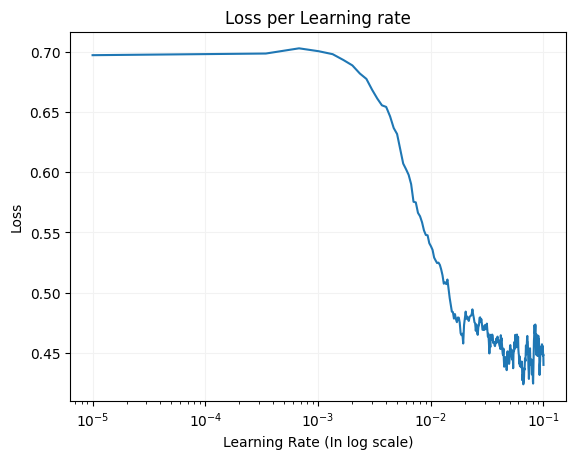

In [51]:
min_lr = 1e-5
max_lr = 1e-1
m_lr = IEEEFeedForwardModel(mp.ModelConfiguration.from_tensor_definitions(ti.target_tensor_def))
o_lr = mp.AdamWOptimizer(m_lr, lr=min_lr)
t_lr = mp.Trainer(m_lr, data_device, train_dl, val_dl)
lrs  = t_lr.find_lr(o_lr, max_lr, 300)
mplt.TrainPlot.plot_lr(lrs);

In [52]:
EPOCHS = 5

# First create a trainer.
trainer = mp.Trainer(model, model_device, train_dl, val_dl)

# Then an optimizer
optimizer = mp.AdamWOptimizer(model, lr=5e-3)

# Set-up a OneCycle Scheduler
scheduler = torch.optim.lr_scheduler.OneCycleLR(
            optimizer=optimizer.optimizer, 
            max_lr=optimizer.lr,
            steps_per_epoch=trainer.number_of_train_steps,
            epochs=EPOCHS
)

# Run the trainer
history = trainer.train(EPOCHS, optimizer, scheduler)

Epoch 005/005: 100%|██████████| 4615/4615 [00:18<00:00, 243.62it/s, t_loss=0.151, t_acc=0.938, v_loss=0.214, v_acc=0.921]      


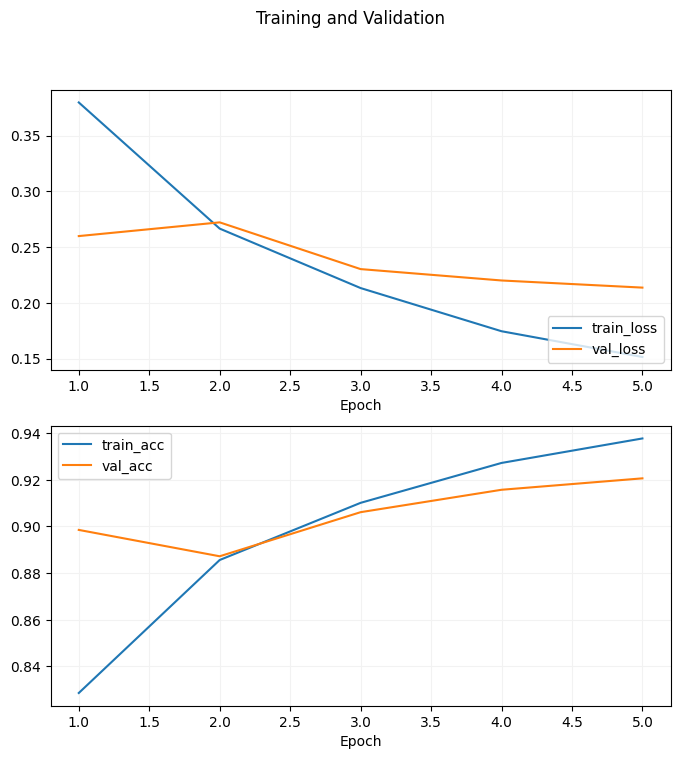

In [53]:
mplt.TrainPlot.plot_history(history, fig_size=(8,8));

In [54]:
t = mp.Tester(model, torch.device(model_device), val_dl)
results = t.test_results_binary()

Testing in 782 steps: 100%|██████████████████| 782/782 [00:01<00:00, 537.06it/s]


------------- Classification report -----------------
              precision    recall  f1-score   support

         0.0       0.99      0.93      0.96     96566
         1.0       0.25      0.65      0.36      3434

    accuracy                           0.92    100000
   macro avg       0.62      0.79      0.66    100000
weighted avg       0.96      0.92      0.94    100000


auc score : 0.8815
ap score  : 0.4635
-----------------------------------------------------


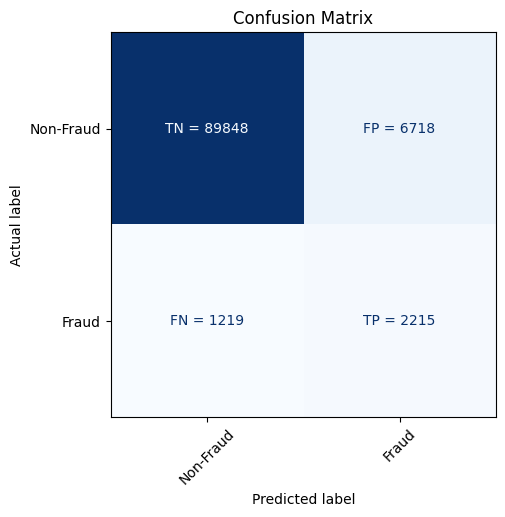

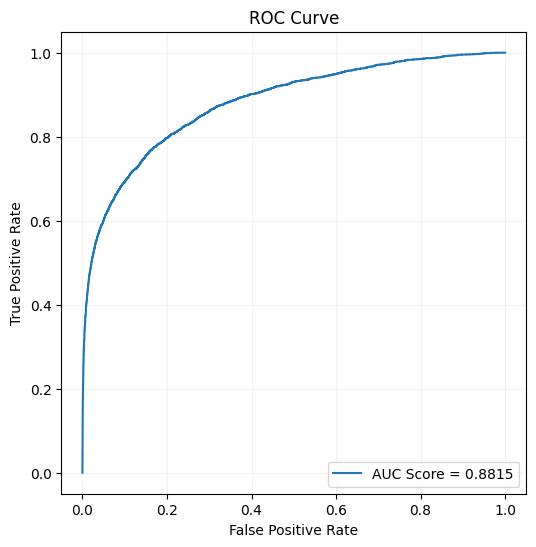

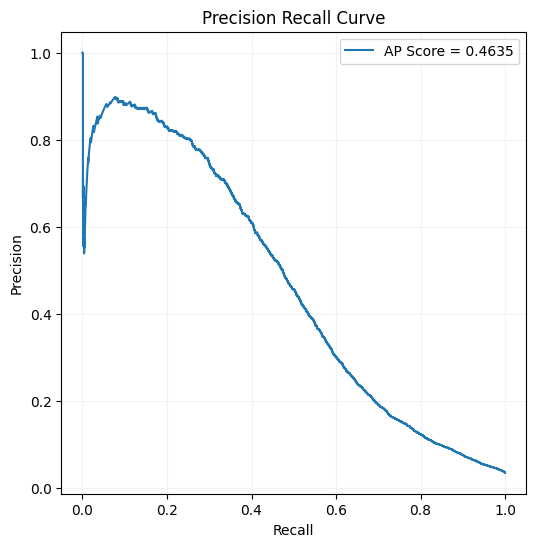

In [55]:
mplt.TestPlot.print_binary_classification_report(results)
mplt.TestPlot.plot_binary_confusion_matrix(results, fig_size=(5,5))
mplt.TestPlot.plot_roc_curve(results, fig_size=(6,6))
mplt.TestPlot.plot_precision_recall_curve(results, fig_size=(6,6))

In [22]:
attr = cp.CaptumAttributions.get_attributions_binary(model, model_device, IntegratedGradients, val_ds[0:5000])

TypeError: CaptumAttributions.get_attributions_binary() missing 1 required positional argument: 'sample'

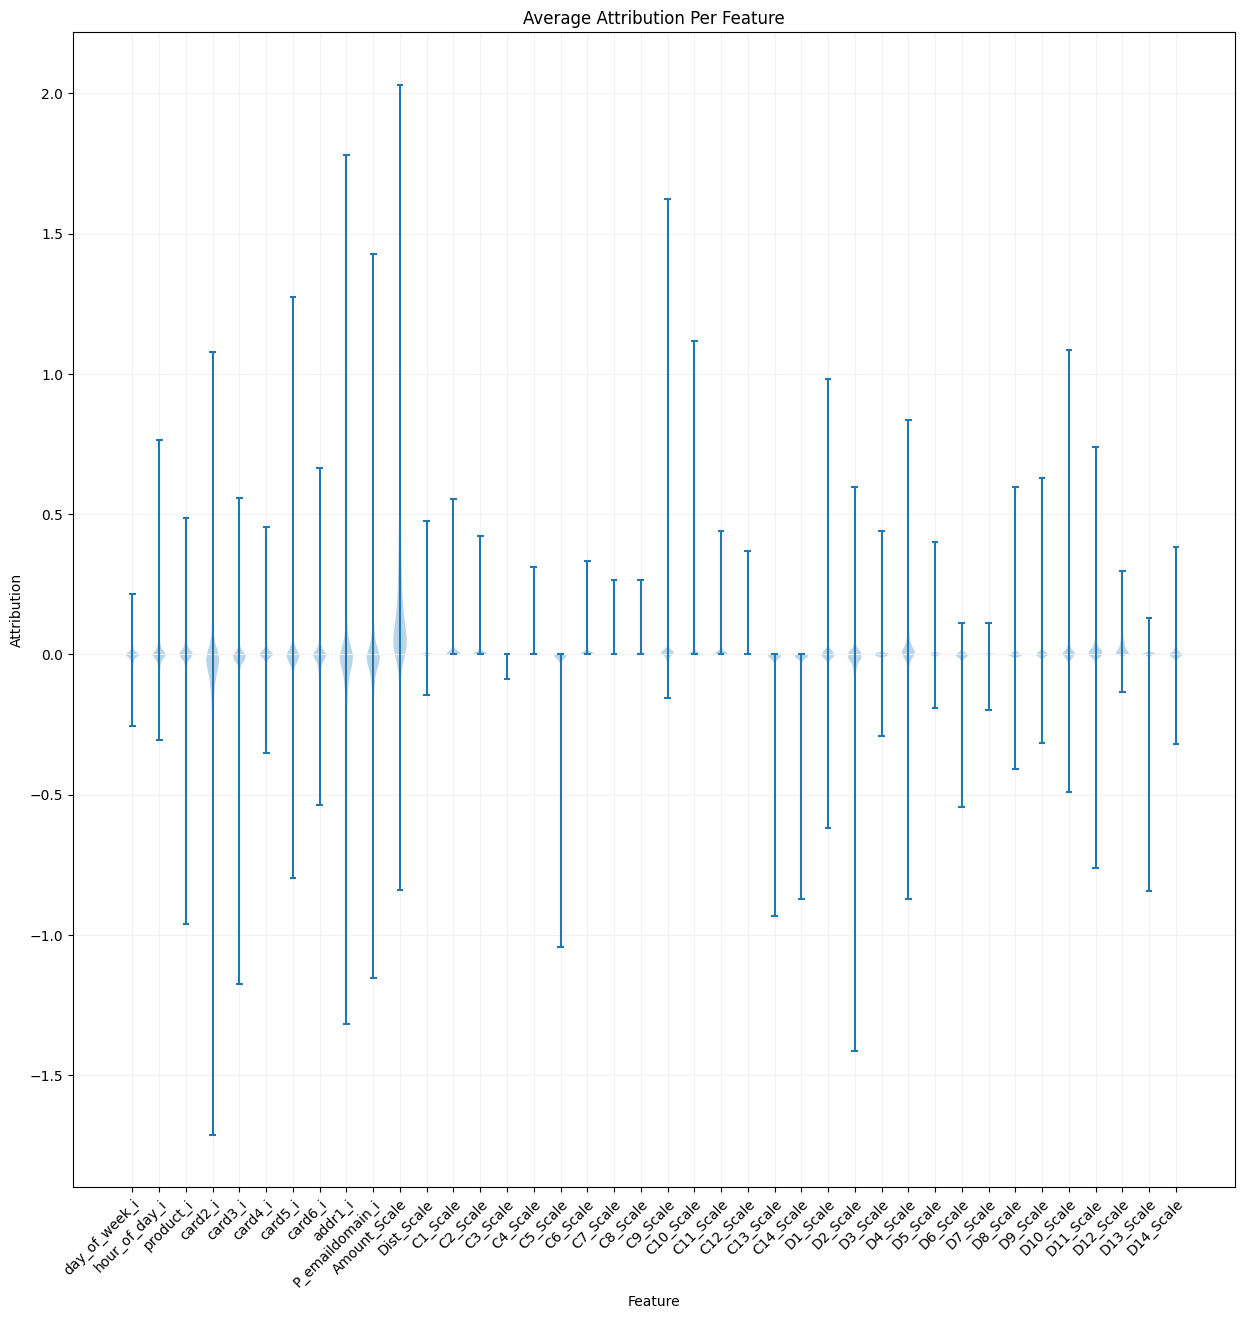

In [32]:
mplt.AttributionPlotBinary.overview(attr,fig_size=(15,15))

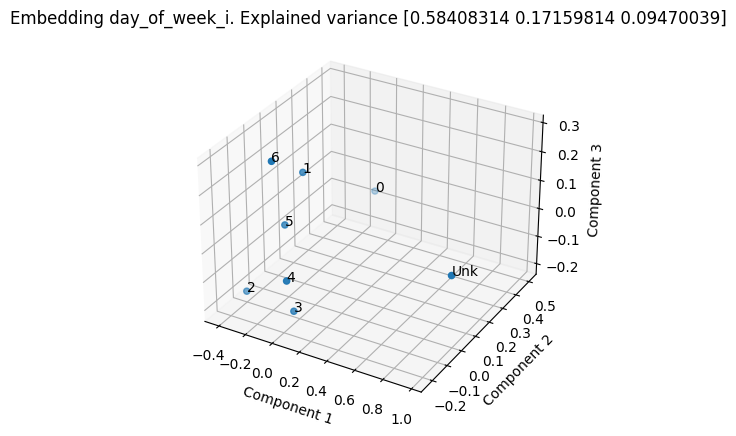

In [33]:
dow_weights = model.heads[0].embedding.embedding_weight(dow_i).detach().cpu().numpy()
mplt.EmbeddingPlot.decompose_and_plot(dow_i, dow_weights, dims=3, fig_size=(5,5))

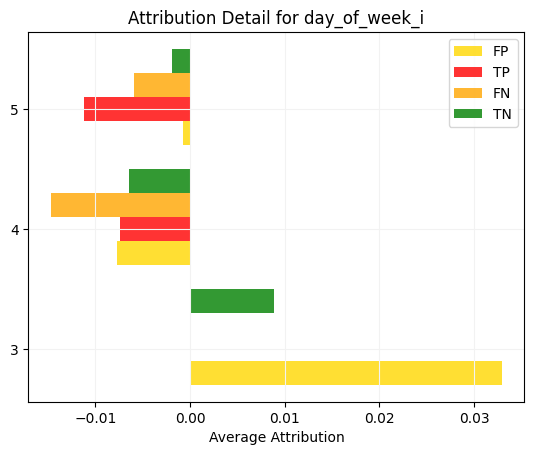

In [34]:
mplt.AttributionPlotBinary.feature_detail(attr, dow_i)

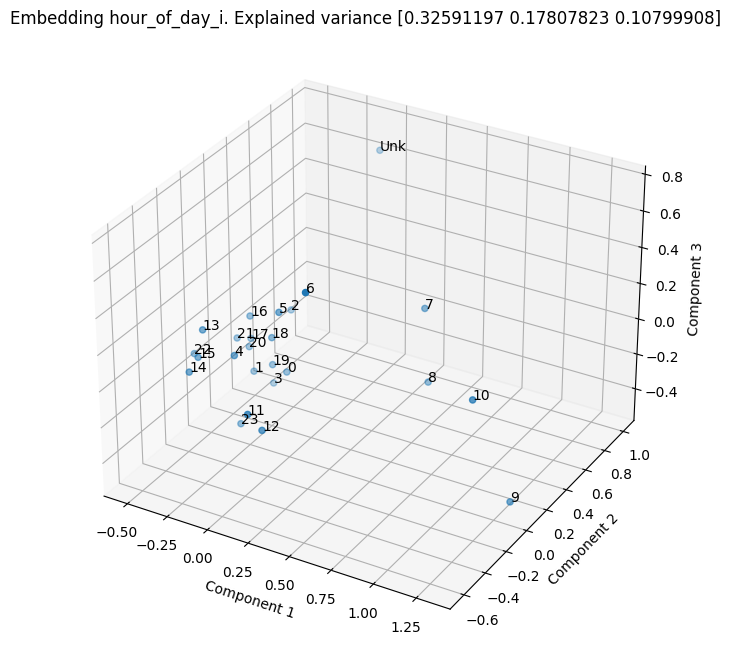

In [35]:
hod_weights = model.heads[0].embedding.embedding_weight(hod_i).detach().cpu().numpy()
mplt.EmbeddingPlot.decompose_and_plot(hod_i, hod_weights, dims=3, fig_size=(8,8))

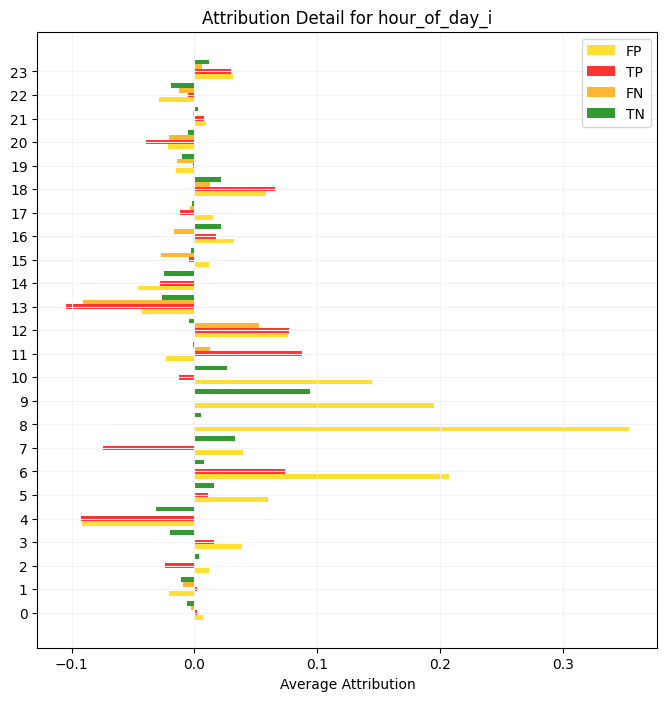

In [36]:
mplt.AttributionPlotBinary.feature_detail(attr, hod_i, fig_size=(8,8))

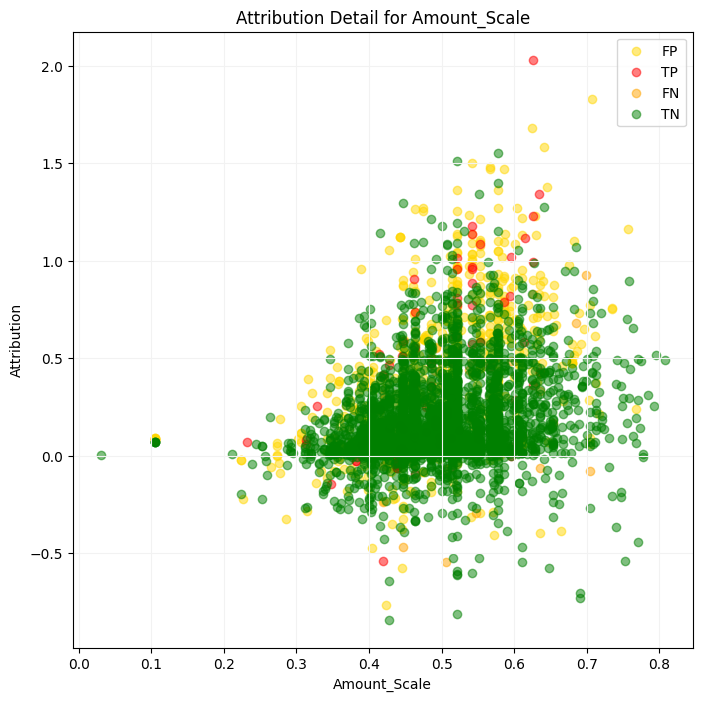

In [37]:
mplt.AttributionPlotBinary.feature_detail(attr, amount_scale, fig_size=(8,8))

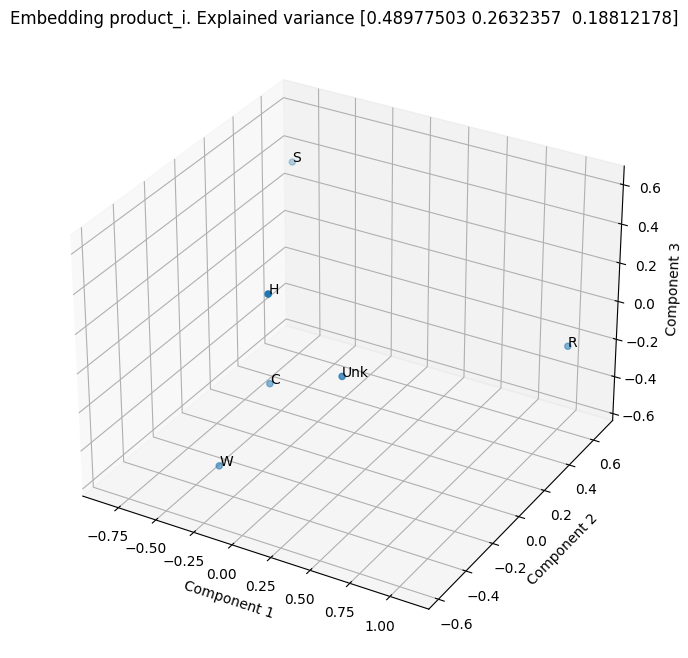

In [54]:
prd_weights = model.heads[0].embedding.embedding_weight(product_i).detach().cpu().numpy()
mplt.EmbeddingPlot.decompose_and_plot(product_i, prd_weights, dims=3, fig_size=(8,8))

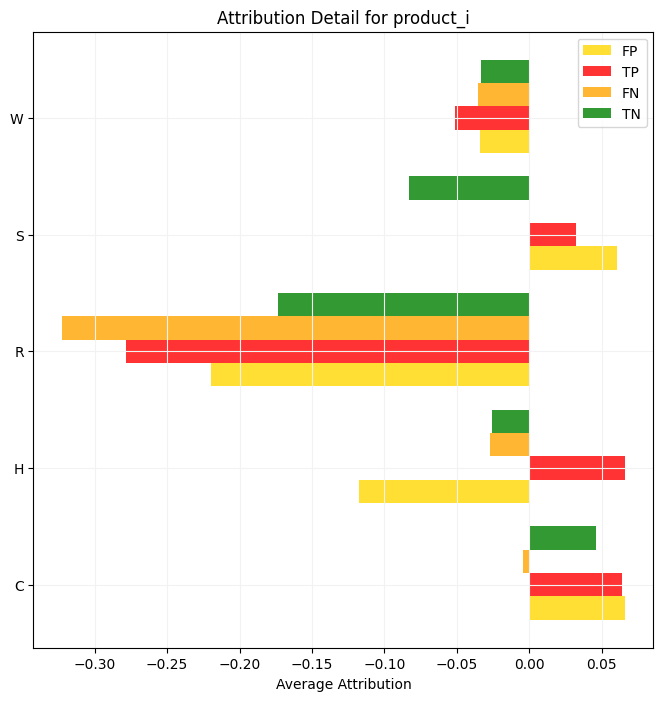

In [52]:
mplt.AttributionPlotBinary.feature_detail(attr, product_i, fig_size=(8,8))